In [3]:
from mpl_toolkits import mplot3d
%matplotlib inline
#import numpy as np
#import matplotlib.pyplot as plt

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np

def proj(X, ax1, ax2):
    x,y,z = X
    x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
    return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))

def image(ax,arr,xy,zoom):
    im = offsetbox.OffsetImage(arr, zoom=zoom)
    im.image.axes = ax
    ab = offsetbox.AnnotationBbox(im, xy, xybox=(-30., 30.),xycoords='data', boxcoords="offset points",
                        pad=0.1, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

def im_sactter3D(xs,ys,zs,colours,images,zoom=1,figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=Axes3D.name)
    ax.scatter(xs, ys, zs, c=colours, marker="o")
    
    ax2 = fig.add_subplot(111,frame_on=False)
    ax2.axis("off")
    for i in range(len(xs)):
        x,y = proj((xs[i],ys[i],zs[i]), ax, ax2)
        image(ax2,images[i],[x,y],zoom)
    plt.show()

def im_sactter2D(xs,ys,colours,images,zoom=1,figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=Axes3D.name)
    ax.scatter(xs, ys, c=colours, marker="o")
    
    ax2 = fig.add_subplot(111,frame_on=False)
    ax2.axis("off")
    for i in range(len(xs)):
        x,y = proj((xs[i],ys[i],zs[i]), ax, ax2)
        image(ax2,images[i],[x,y],zoom)
    plt.show()
    
def em_scatter(x,y,z,colours,plot_size=200):
    fig = plt.figure(figsize=(30,30))
    ax = plt.axes(projection='3d')    
    s=[plot_size for i in range(len(x))]
    if z:
        ax.scatter(x, y,z,s=s,c=colours,marker='o');
    else:
        ax.scatter(x, y,s=s,c=colours,marker='o');
    #ax.view_init(15,30)
    #plt.scatter(x,y,z)

In [7]:
import os,sys
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE as tsne
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# class fsort:

# def __init__():
#     return  
imagenetdir=os.path.expandvars('$HOME/dev/resources/imagenet')
def scatter(dir,points, images, zoom=1):
    fig,ax=plt.subplots()
    for (x, y), image in zip(points, images):
        im = OffsetImage(Image.open(dir+'/'+image),zoom=zoom)
        ab = AnnotationBbox(im, (x, y), frameon=True, pad=0.2)
        ax.add_artist(ab)
    plt.show()  

def create_graph():
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(imagenetdir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='') 

def get_pool_arr(dir):
  create_graph()
  pool_list=[]
  flst=[]
  with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    print("Dir:"+dir)
    for image in os.listdir(dir):
      s=image.split('.')
      if not s or s[-1] not in ['jpg','jpeg','png']:
            continue
      try:
        print(image,end=", ")
        if not tf.gfile.Exists(dir+"/"+image):
          tf.logging.fatal('%s does not exist'%image)        
        with tf.gfile.FastGFile(dir+"/"+image, 'rb') as image_file:
          image_data =  image_file.read()
          predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
          predictions = np.squeeze(predictions)          
          feature_tensor = sess.graph.get_tensor_by_name('pool_3:0')
          #feature_set = sess.run(feature_tensor, {'DecodeJpeg/contents:0': image_data})
          val_lst=sess.run(feature_tensor)[0][0][0]
          pool_list.append(val_lst)
          flst.append(image)
      except Exception as e:
        print("\nException while generating pool list\n%r"%e)
  return (flst,np.array(pool_list))

def run_tsne(pool_arr,dims=1,prplx=30,iters=1000,lr=200):
    #pca_m=PCA(n_components=360)
    pca_res=pool_arr
    #pca_res=pca_m.fit_transform(pool_arr)
    ts_model=tsne(n_components=dims,perplexity=prplx,n_iter=iters,learning_rate=lr)
    embeddings=ts_model.fit_transform(pca_res)
    return embeddings   

def sort(dir,dims=1,prplx=30,iters=1000,lr=200):
    pool_info=get_pool_arr(dir)
    embeddings=run_tsne(pool_info[1],dims,prplx,iters,lr)
    #result={}
    #for k in range(len(embeddings)):
    #    result[pool_info[0][k]]=embeddings[k].tolist()[0]
    #result=sorted([(v,k) for k,v in result.items() ])
    return (pool_info[0],embeddings)    

In [43]:
dir=os.path.expandvars('$HOME/devloka/tf')
res=sort(dir,2,28,1000,100)
images=[Image.open(dir+'/'+imfile) for imfile in res[0] ]
em_lst=res[1].tolist()
x = [i[0] for i in em_lst ]
y = [i[1] for i in em_lst ]
#z = [i[2] for i in em_lst ]
z=None
colours=['red' if 'doggo' in fn else 'blue' for fn in res[0]]

Dir:/home/gk1000/devloka/tf
gknh.jpg, z99hh.jpg, zbjhbjhvb.jpg, kpokpjjp.jpg, doggo9.jpg, uehfiudshf.jpg, doggo7.jpg, l;m;lkjk.jpg, doggo13.jpg, doggo17.jpg, doggo15.jpg, nnihni.jpg, oopo.jpg, doggo19.jpg, oiononjn.jpg, ooohbb.jpg, hih9bb.jpg, z9jhbv.jpg, z6546884.jpg, doggo12.jpg, nkjnlojij.jpg, nlnlk.jpg, zdi[0da.jpg, j99jon.jpg, z9juh.jpg, doggo10.jpg, doggo2.jpg, jpjojopj.jpg, z00inn.jpg, odpifspoid.jpg, iuy87ti.jpg, z9dic.jpg, kmn0.jpg, vcytgjk.jpg, lmlmml.jpg, opkij9.jpg, hhgi.jpg, doggo11.jpg, z0dfsd8fs.jpg, doggo20.jpg, jbhjhj.jpg, kjkllk.jpg, hiuhojkpo.jpg, doggo14.jpg, kpopnn.jpg, doggo6.jpg, za98y9h9bnj.jpg, hv8.jpg, owfiw7.jpg, miojo9.jpg, ojoj.jpg, knmnk.jpg, doggo5.jpg, uhib9.jpg, doggo8.jpg, oohh89.jpg, lknnlnln.jpg, doggo3.jpg, doggo18.jpg, z4458.jpg, doggo1.jpg, nooiuo.jpg, doggo4.jpg, njn.jpg, doggo16.jpg, 

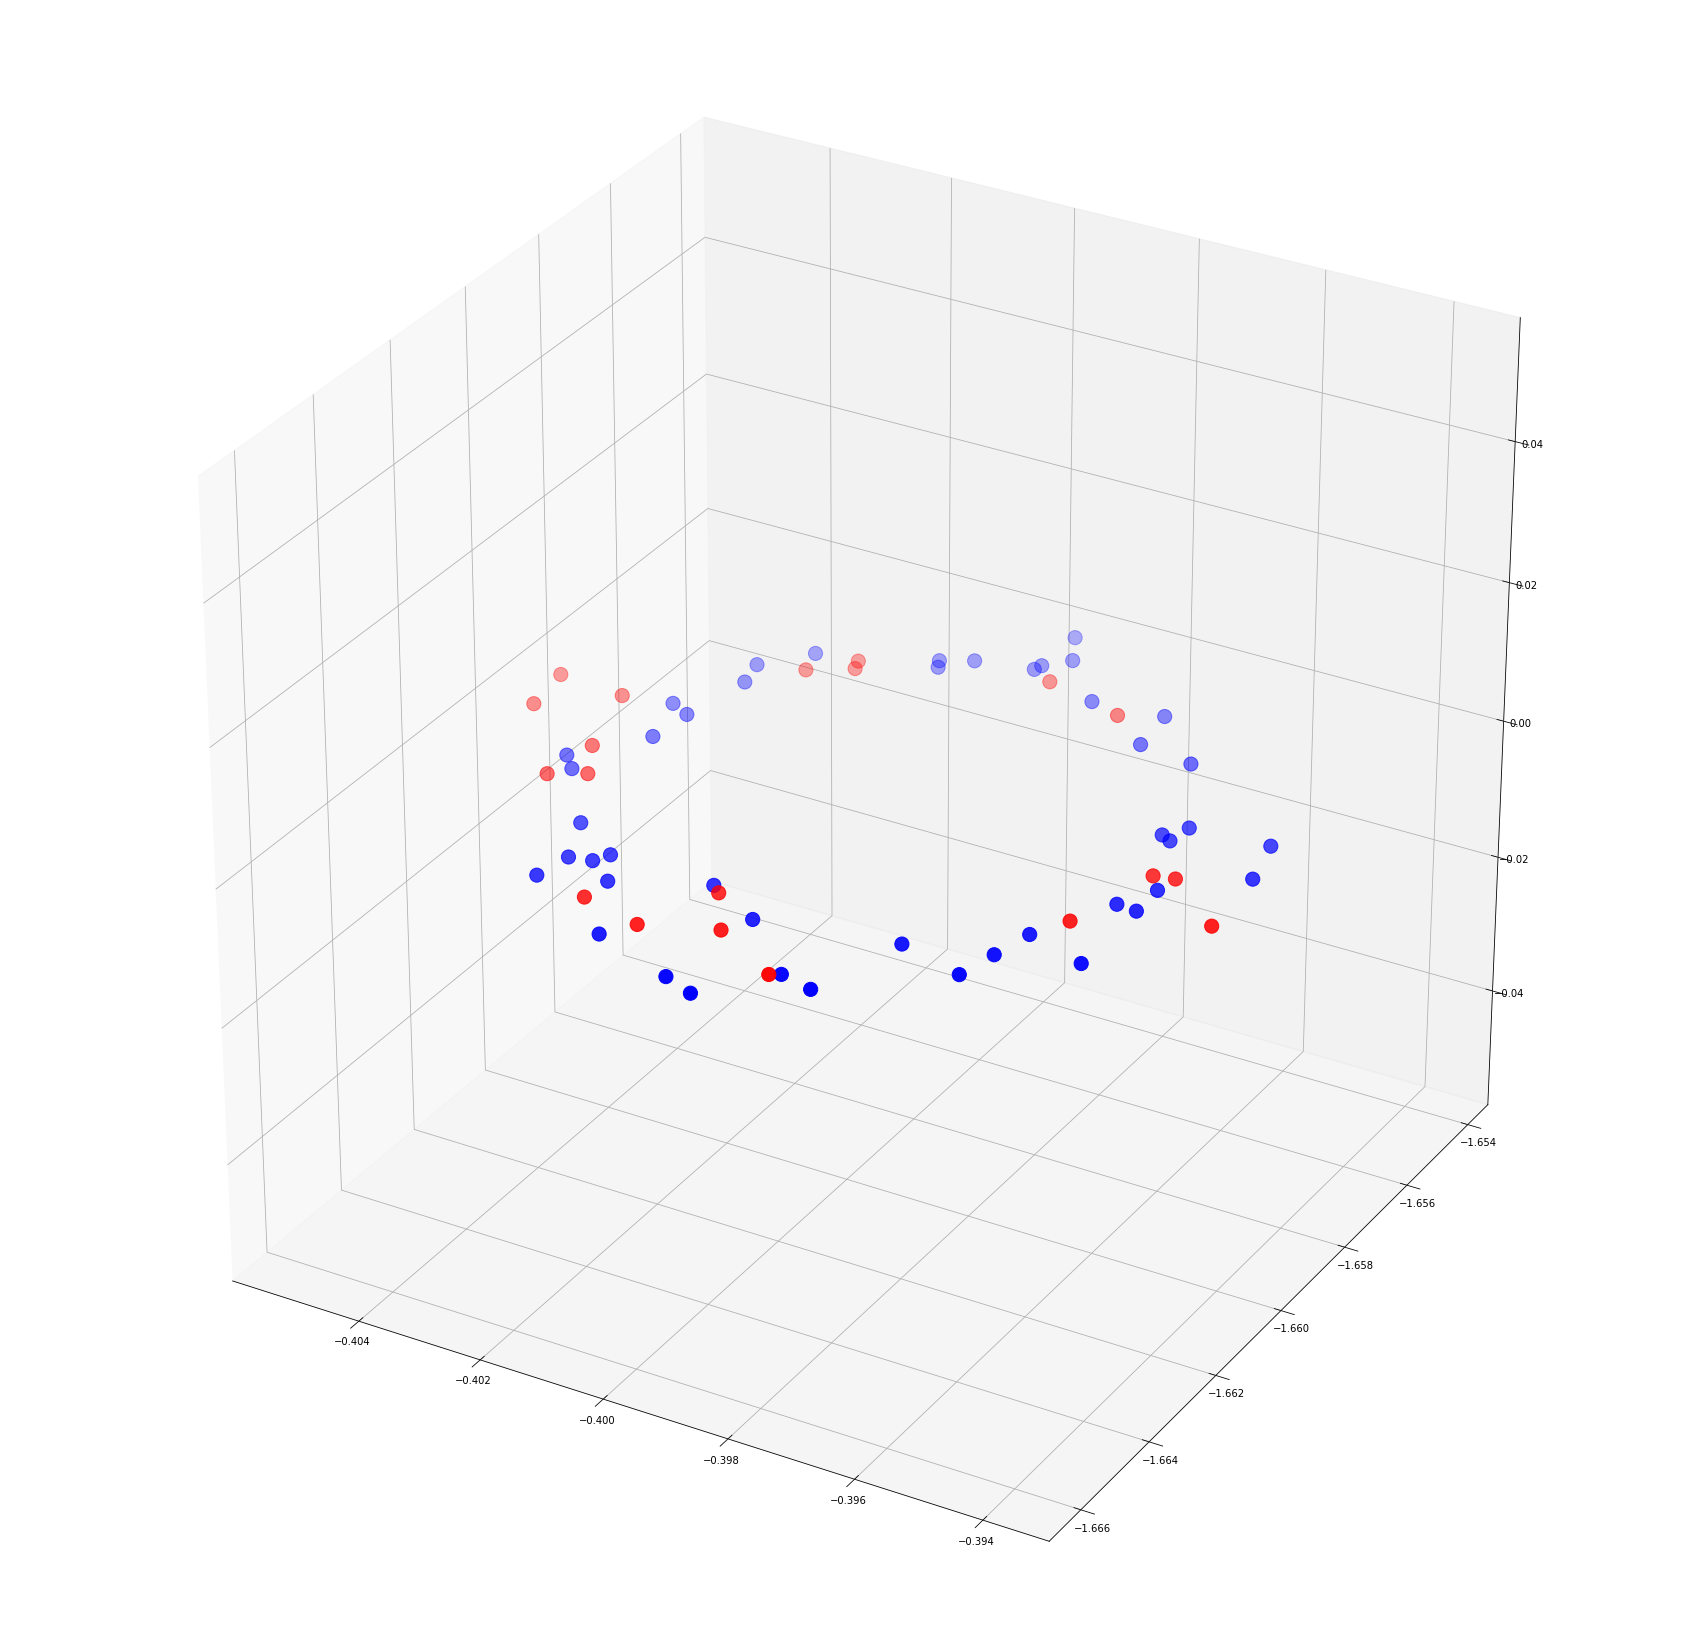

In [44]:
em_scatter(x,y,None,colours)